In [1]:
import datetime

import colormaps
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import xarray as xr
from jetutils.anyspell import get_persistent_jet_spells, mask_from_spells_pl, subset_around_onset, get_persistent_spell_times_from_som, get_spells, extend_spells, gb_index, make_daily
from jetutils.clustering import Experiment, RAW_REALSPACE, labels_to_centers
from jetutils.data import *
from jetutils.geospatial import *
from jetutils.definitions import *
from jetutils.jet_finding import *
from jetutils.plots import *
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from pathlib import Path
from tqdm import tqdm
import polars.selectors as cs

%load_ext IPython.extensions.autoreload
%autoreload 2
%matplotlib inline

IPython could not be loaded!


Found config override file at  /storage/homefs/hb22g102/.jetutils.ini
Guessed N_WORKERS :  10
Guessed MEMORY_LIMIT :  204800


In [2]:
all_times = (
    pl.datetime_range(
        start=pl.datetime(1959, 1, 1),
        end=pl.datetime(2023, 1, 1),
        closed="left",
        interval="6h",
        eager=True,
        time_unit="ms",
    )
    .rename("time")
    .to_frame()
)
summer_filter = (
    all_times
    .filter(pl.col("time").dt.month().is_in([6, 7, 8, 9]))
    .filter(pl.col("time").dt.ordinal_day() > 166)
)
summer = summer_filter["time"]
summer_daily = summer.filter(summer.dt.hour() == 0)
big_summer = all_times.filter(pl.col("time").dt.month().is_in([6, 7, 8, 9]))
big_summer_daily = big_summer.filter(big_summer["time"].dt.hour() == 0)
dh = DataHandler.from_specs(
    "ERA5",
    "surf",
    ("alot2pvu", None),
    "6H",
    "all",
    None,
    -80,
    40,
    15, 
    80,
)
exp = JetFindingExperiment(dh)
ds = exp.ds
all_jets_one_df = exp.find_jets(force=False, alignment_thresh=0.7, base_s_thresh=0.6, int_thresh_factor=0.6, hole_size=6)

theta250 = open_da("ERA5", "plev", ("uv", ["u", "v", "theta"]), "6H", period=(1959, 2023), minlon=-80, maxlon=40, minlat=15, maxlat=80, levels=250)
theta250["s"] = np.sqrt(theta250["u"] ** 2 + theta250["v"] ** 2)
theta250 = theta250.drop_vars(["u", "v"])
theta250 = theta250.rename({"s": "s250", "theta": "theta250"})
all_jets_one_df = add_feature_for_cat(all_jets_one_df, "s250", theta250, ofile_ajdf=exp.path.joinpath("all_jets_one_df.parquet"), force=False)
all_jets_one_df = add_feature_for_cat(all_jets_one_df, "theta250", theta250, ofile_ajdf=exp.path.joinpath("all_jets_one_df.parquet"), force=False)
all_jets_one_df = exp.categorize_jets(None, ["s", "theta"], force=False, n_init=25, init_params="k-means++", mode="week", v2=False).cast({"time": pl.Datetime("ms")})

props_uncat = exp.props_as_df(False, force=1).cast({"time": pl.Datetime("ms")})
props_as_df = average_jet_categories(props_uncat, polar_cutoff=0.5)

props_summer = summer_filter.join(props_as_df, on="time")
phat_filter = (pl.col("is_polar") < 0.5) | ((pl.col("is_polar") > 0.5) & (pl.col("int") > 1.5e8))

phat_jets = all_jets_one_df.filter((pl.col("is_polar").mean().over(["time", "jet ID"]) < 0.5) | ((pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5) & (pl.col("int").mode().first().over(["time", "jet ID"]) > 1.5e8)))
phat_jets_catd = phat_jets.with_columns(**{"jet ID": (pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5).cast(pl.UInt32())})
phat_props = props_uncat.filter(phat_filter)
phat_props_catd = average_jet_categories(phat_props, polar_cutoff=0.5)

phat_props_catd = phat_props_catd.join(phat_props_catd.rolling("time", period="2d", group_by="jet").agg(**{f"{col}_var": pl.col(col).var() for col in ["mean_lon", "mean_lat", "mean_s", "s_star"]}), on=["time", "jet"])
phat_props_catd_summer = summer_filter.join(phat_props_catd, on="time")

In [3]:
# cross_catd = track_jets(phat_jets_catd, n_next=1)
# cross_catd.write_parquet(exp.path.joinpath("cross_catd.parquet"))

cross_catd = pl.read_parquet(exp.path.joinpath("cross_catd.parquet"))
cross_catd = squarify(summer_filter.join(cross_catd[["jet ID"]].unique("jet ID"), how="cross").join(cross_catd, on=["time", "jet ID"], how="left"))

spells_list = spells_from_cross_catd(cross_catd, base_q=0.6, season=summer, q_STJ=0.75, q_EDJ=0.86, minlen=datetime.timedelta(days=4))

for name, spell in spells_list.items():
    print(name, spell["spell"].n_unique())

kwargs = dict(time_before=datetime.timedelta(hours=24), time_after=datetime.timedelta(hours=24))
daily_spells_list = {a: make_daily(b, "spell", ["len", "spell_of"]) for a, b in spells_list.items()}

STJ 20
EDJ 20


## does it work

100%|██████████| 12/12 [00:15<00:00,  1.31s/it]


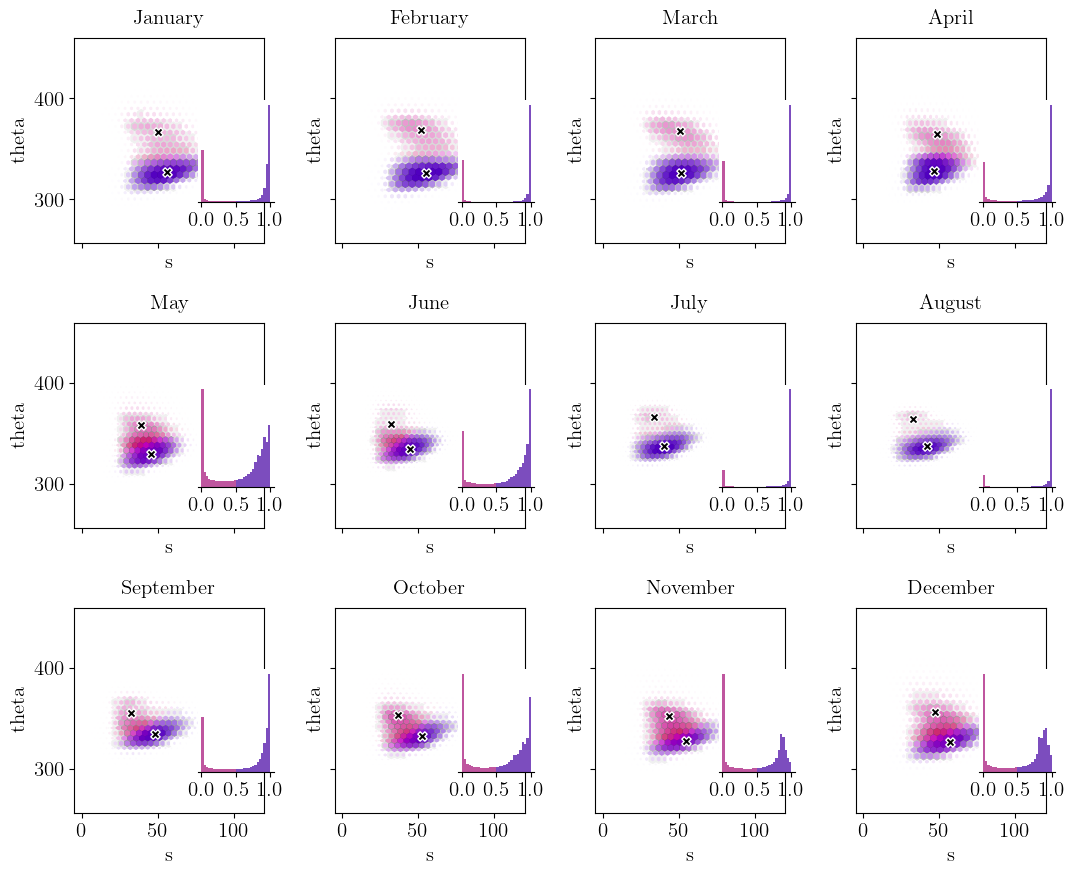

In [4]:
xys = []
all_jets = all_jets_one_df.filter(pl.col("int") > 1.1e8)
# .filter(pl.col("int") > 1.1e8)

xys = np.array(xys)
fig, axes = plt.subplots(3, 4, figsize=(11, 9), tight_layout=True, sharex="all", sharey="all")
axes = axes.ravel()
pair = ["s", "theta", "is_polar"]
cmap = LinearSegmentedColormap.from_list("pinkredpurple", [COLORS[2], COLORS_EXT[10], COLORS[1]])
bins = np.linspace(0, 1, 31)
for month in trange(1, 13):
    ax = axes[month - 1]
    X = extract_features(all_jets, pair, season=month)
    probas = X[pair[2]]
    center_stj = X.filter(pl.col("is_polar") < 0.3).mean()
    center_edj = X.filter(pl.col("is_polar") > 0.7).mean()
    X1D = X["is_polar"]
    
    im1 = ax.hexbin(X[pair[0]], X[pair[1]], cmap=colormaps.gray_r, gridsize=25)
    im2 = ax.hexbin(X[pair[0]], X[pair[1]], C=probas, cmap=colormaps.gray_r, gridsize=25)
    
    plt.draw()
        
    offsets1 = np.asarray(list(map(tuple, im1.get_offsets())), dtype="f, f")
    offsets2 = np.asarray(list(map(tuple, im2.get_offsets())), dtype="f, f")
    mask12 = np.isin(offsets1, offsets2)
    colors = cmap(im2.get_array())
    colors = rgb_to_hsv(colors[:, :3])
    min_s, max_s = 0., 1.0
    min_v, max_v = 0.75, 1.
    scaling = np.clip(im1.get_array()[mask12] / im1.get_array()[mask12].max() * 1.1, 0, 1)
    f = lambda x: np.sqrt(x)
    colors[:, 1] = min_s + scaling * (max_s - min_s)
    colors[:, 2] = max_v - scaling * (max_v - min_v)
    colors = hsv_to_rgb(colors)
    im2.set_array(None)
    im2.set_facecolor(colors)
    # im2.set_linewidths(0.2)
    im2.set_linewidths(4 * (1 - f(scaling)) ** 2)
    im2.set_edgecolor(colormaps.greys(scaling))
    im2 = ax.add_collection(im2)
        
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
    if pair[0] in ["lev", "theta"]:
        ax.invert_xaxis()
    elif pair[1] in ["lev", "theta"]:
        ax.invert_yaxis() 
        
    ax.set_title(MONTH_NAMES[month - 1])
    ax.scatter(*pl.concat([center_stj, center_edj])[pair[:2]].to_numpy().T, facecolor="black", edgecolor="white", marker="X", linewidths=1, s=45)
    iax = ax.inset_axes([0.65, 0.2, 0.4, 0.5])
    X1D = np.clip(X1D, 0, 1)
    iax.hist(X1D, bins=bins, alpha=0.5, color="black")
    iax.hist(X1D[probas > 0.5], bins=bins, alpha=0.5, color=COLORS[1])
    iax.hist(X1D[probas < 0.5], bins=bins, alpha=0.5, color=COLORS[2])
    iax.set_xticks([0, 0.5, 1])
    iax.set_yticks([])
    iax.spines[["left", "right", "top"]].set_visible(False)
    plt.draw()
# fig.savefig(f"{FIGURES}/jet_detection_demo/gmix_demo")

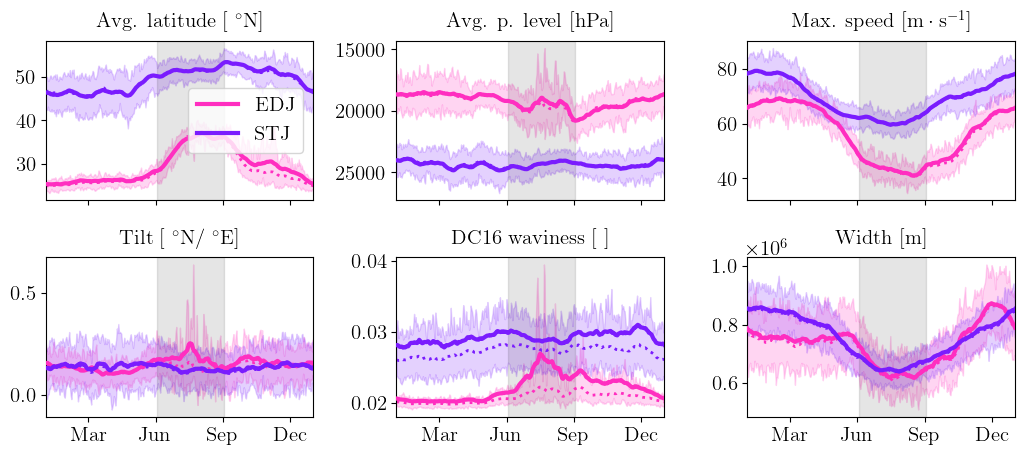

In [5]:
data_vars = [
    "mean_lat",
    "mean_lev",
    "s_star",
    "tilt",
    "wavinessDC16",
    "width",
]
_ = plot_seasonal(
    props_as_df, data_vars, nrows=2, ncols=3, clear=False, save=False,
)

## jet centric datasets

In [ ]:
def create_jet_relative_dataset(jets, path, da, suffix="", half_length: float = 20.):
    indexer = iterate_over_year_maybe_member(jets, da)
    to_average = []
    varname = da.name + "_interp"
    for idx1, idx2 in tqdm(indexer, total=len(YEARS)):
        jets_ = jets.filter(*idx1)
        da_ = da.sel(**idx2)
        try:
            jets_with_interp = gather_normal_da_jets(jets_, da_, half_length=half_length)
        except (KeyError, ValueError) as e:
            print(e)
            break
        jets_with_interp = interp_jets_to_zero_one(jets_with_interp, [varname, "is_polar"], n_interp=30)
        jets_with_interp = jets_with_interp.group_by("time", pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5, "norm_index", "n", maintain_order=True).agg(pl.col(varname).mean())
        to_average.append(jets_with_interp)
    pl.concat(to_average).write_parquet(path.joinpath(f"{da.name}{suffix}_relative.parquet"))
    
args = ["all", None, -100, 60, 0, 90]
path = exp.path

# Persistence quantiles vs props

In [4]:
import CDSK

da_ = coarsen_da(exp.ds["s"].sel(time=np.isin(exp.ds.time.dt.month, [6, 7, 8, 9])), 4, np.amax)
# da_anom = compute_anomalies_ds(da_, "dayofyear", standardized=True).sel(time=np.isin(da_.time.dt.month, [6, 7, 8, 9]))
X = da_.values.reshape(da_.shape[0], -1)

In [5]:
opath_dim = exp.path.joinpath("dim.parquet")
opath_theta = exp.path.joinpath("theta.parquet")
if opath_dim.is_file() and opath_theta.is_file():
    dim_pd = pl.read_parquet(opath_dim)
    theta_pd = pl.read_parquet(opath_theta)
else:
    a, b, c = CDSK.dynamical_local_indexes(X, n_jobs=N_WORKERS)
    dim = a[:, 0, 0]
    theta = b[:, 0, 0]
    dim_pd = pl.DataFrame({"time": da_.time.values, "dim": dim})
    theta_pd = pl.DataFrame({"time": da_.time.values, "theta": theta})
    dim_pd.write_parquet(opath_dim)
    theta_pd.write_parquet(opath_theta)

In [6]:
speed_realspace = ((da_[1:].data - da_[:-1].data) ** 2).sum(axis=(1, 2))
speed_pd = pl.DataFrame({"time": da_.time.values[:-1], "speed": speed_realspace})
pers = pl.read_parquet(exp.path.joinpath("pers_catd_all_year.parquet"))

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True)
axes = axes.ravel()
for i, to_plot in enumerate([dim_pd, theta_pd, speed_pd]):
    ax = axes[i]
    name = to_plot.columns[-1]
    for jet in ["STJ_catd", "EDJ_catd"]:
        spells = spells_list[jet]
        huh = mask_from_spells_pl(spells_list[jet], to_plot, time_before=datetime.timedelta(days=4))
        x, y = huh.group_by("relative_index").mean().sort("relative_index")[["relative_index", name]].to_numpy().T
        x = x / 4
        ax.plot([x[0], x[-1]], [to_plot[name].mean()] * 2, color="black")
        ax.plot(x, y, color=COLORS[2 - int(jet=="EDJ_catd")], lw=3, label=jet[:3])
    ax.set_xlabel("Relative time around offset [day]")
axes[0].set_title("Local dimension $d$")
axes[1].set_title(r"Extremal factor $\theta$")
axes[0].legend(ncol=2)
fig.savefig(f"{FIGURES}/jet_persistence/dst.png")

In [8]:
from itertools import pairwise
props_as_df_anoms = compute_anomalies_pl(phat_props_catd.filter(pl.col("time").dt.month().is_in([6, 7, 8, 9])), standardize=True)
from jetutils.jet_finding import pers_from_cross_catd
pers = pl.read_parquet(exp.path.joinpath("pers_catd_all_year.parquet")).filter(pl.col("time").dt.month().is_in([6, 7, 8, 9]))
n_q = 31
data_vars = [
    "mean_lat",
    "mean_theta",
    "mean_s",
    "tilt",
    "waviness1",
    "width",
]
prettier_index = {
    "theta": "Inv. DST extremal index",
    "dim": "DST local dimension",
    "speed": "Inv. T2T distance",
    "pers": "Jet persistence",
}
cm = colormaps.bold
colors_props = cm(np.linspace(0, 1 - 1 / cm.N, cm.N) + 1 / 2 / cm.N)
vs_quantiles = {
    data_var: np.zeros(n_q - 1) for data_var in data_vars
}
qs = np.linspace(0, 1, n_q)
to_plots = {"theta": theta_pd, "dim": dim_pd, "speed": speed_pd, "pers": pers}
fig, axes = plt.subplots(len(to_plots), 2, figsize=(10, 10), sharex="all", sharey="col", gridspec_kw={"hspace": 0.23})
for i, (name, to_plot) in enumerate(to_plots.items()):
    name = to_plot.columns[-1]
    for j, jet in enumerate(["STJ", "EDJ"]):
        ax = axes[i, j]
        if name=="pers":
            to_plot_ = to_plot.filter(pl.col("spell_of") == jet)
        elif name in ["theta", "speed"]:
            to_plot_ = to_plot.with_columns(1 / pl.col(name))
        else:
            to_plot_ = to_plot
        to_plot_ = to_plot.cast({"time": pl.Datetime("ms")})
        for k, (q1, q2) in enumerate(pairwise(qs)):
            props = (
                to_plot_
                .filter(
                    (pl.col(name) < pl.col(name).quantile(q2)) & 
                    (pl.col(name) >= pl.col(name).quantile(q1))
                )[["time"]]
                .join(
                    props_as_df_anoms
                    .filter(pl.col("jet") == jet), 
                    on="time"
                )
                .mean()
            )
            for data_var in data_vars:
                vs_quantiles[data_var][k] = props[data_var].item()
            ax.axhline(0, color="black")
        for k, (data_var, huh) in enumerate(vs_quantiles.items()):
            ax.plot((qs[:-1] + qs[1:]) / 2, huh, label=PRETTIER_VARNAME[data_var], color=colors_props[k], lw=2)
        ax.set_title(f"{prettier_index[name]}, props. of the {jet[:3]}", pad=4)
fig.supxlabel("Quantile of the persistence prop.", y=0.05)
fig.supylabel("Standardized anomaly of the jet property", x=0.06)
axes[-1, 0].legend(bbox_to_anchor=[2, -.35], ncol=3, title="Jet properties")
axes[-1, -1].set_xlim([0, 1])
fig.savefig(f"{FIGURES}/jet_persistence/pers_props_quantiles.png")

In [9]:
pers.filter((pl.col("pers") < pl.col("pers").quantile(q2)) & (pl.col("pers") >= pl.col("pers").quantile(q1)))[["time"]].join(props_as_df_anoms.filter(pl.col("jet") == "EDJ"), on="time").mean()

# grams weather regimes

In [4]:
dh = DataHandler.from_specs("ERA5", "plev", "z", "6H", "all", [6, 7, 8, 9], -80, 40, 15, 80, 500, "dayofyear", {"dayofyear": ("win", 15)}, None)

exp_z = Experiment(dh)
centers_z, labels_z = exp_z.do_kmeans(4, 30, weigh_grams=False)

coslat = np.cos(np.deg2rad(centers_z.lat))
Pwr = (dh.da * centers_z * coslat).sum(["lon", "lat"]) / coslat.sum() / centers_z.lon.shape[0]
Iwr = (Pwr - Pwr.mean("time")) / Pwr.std("time", ddof=0)
Iwr = compute(Iwr)
Iwr = xarray_to_polars(Iwr.rename("Iwr")).drop("ratio", "label")

# Iwr = Iwr.with_columns(year=pl.col("time").dt.year())
sigma_wr = Iwr["Iwr"].std()
winner = Iwr.group_by("time", maintain_order=True).agg(pl.col("Iwr").arg_max().alias("winner"), pl.col("Iwr").max(), pl.col("time").dt.year().alias("year").first())
winner = winner.with_columns(winner=pl.when(pl.col("Iwr") > sigma_wr).then(1 + pl.col("winner")).otherwise(pl.lit(0)))
start_of_year = winner.group_by("year", maintain_order=True).len().with_columns(start_of_year=pl.col("len").cum_sum() - pl.col("len").get(0)).drop("len")
to_zero = (
    winner
    .group_by("year", maintain_order=True)
    .agg(pl.col("winner").rle().alias("rle"))
    .explode("rle")
    .unnest("rle")
    .group_by("year", maintain_order=True)
    .agg(
        len=pl.col("len"),
        start=pl.lit(0).append(
            pl.col("len").cum_sum().slice(0, pl.col("len").len() - 1)
        ),
        value=pl.col("value"),
    )
    .explode(["len", "start", "value"])
    .join(start_of_year, on="year")
    .with_columns(start=pl.col("start") + pl.col("start_of_year"))
    .drop("start_of_year")
    .filter(pl.col("len") < 20, pl.col("value") > 0)
    .drop("value")
    .with_columns(
        index=pl.int_ranges(pl.col("start"), pl.col("start") + pl.col("len"))
    )
    .drop("len", "start")
    .explode("index")
)[:, "index"]
winner[to_zero, "winner"] = 0

mask_updated = labels_to_mask(winner[:, "winner"].to_numpy())

In [ ]:
["Greenland Blocking", "Zonal regime", "EuBL/AR", "ScBl"]
["NAO-", "AL", "AR", "ScBl"]

['Greenland Blocking', 'Zonal regime', 'EuBL/AR', 'ScBl']

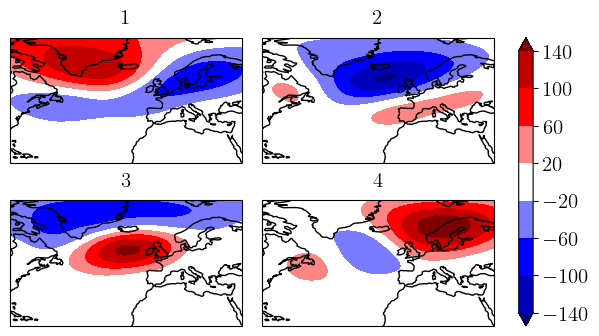

In [12]:
clu = Clusterplot(2, 2, get_region(exp_z.da))
clu.add_contourf([dh.da[winner["winner"] == i].mean("time") / 9.8 for i in range(1, 5)], cmap=colormaps.BlWhRe, levels=[-140, -100, - 60, -20, 20, 60, 100, 140], titles=[str(i) for i in range(1, 5)])
clu.fig.savefig(f"{FIGURES}/jet_persistence/summer_wrs_def.png")

In [11]:
dh.path.joinpath("grams_wr.parquet")

PosixPath('/storage/workspaces/giub_meteo_impacts/ci01/ERA5/plev/z/6H/dayofyear_doywin15/results/2/grams_wr.parquet')

In [9]:
winner.write_parquet(dh.path.joinpath("grams_wr.parquet"))

# Jet relative stuff

In [4]:
args = ["all", [6, 7, 8, 9], *get_region(ds), "all"]
da_T = DataHandler.from_specs(
    "ERA5",
    "surf",
    "t2m",
    "dailymean",
    *args,
).da
da_T = compute(da_T, progress_flag=True)
da_tp = DataHandler.from_specs(
    "ERA5",
    "surf",
    "tp",
    "dailysum",
    *args,
).da
da_tp = compute(da_tp, progress_flag=True)
da_pv330 = DataHandler.from_specs(
    "ERA5",
    "thetalev",
    "PV330",
    "dailymean",
    *args,
).da.rename("PV330")
da_pv330 = compute(da_pv330, progress_flag=True)
da_pv350 = DataHandler.from_specs(
    "ERA5",
    "thetalev",
    "PV350",
    "dailymean",
    *args,
).da
da_pv350 = compute(da_pv350, progress_flag=True)
da_theta2pvu = DataHandler.from_specs(
    "ERA5",
    "surf",
    "theta2PVU",
    "dailymean",
    *args,
).da
da_theta2pvu = compute(da_theta2pvu, progress_flag=True)
varnames_rwb = ["APVO", "CPVO"]#, "SAPVS", "SCPVS", "TAPVS", "TCPVS"]
das_rwb = {}
for var in varnames_rwb:
    das_rwb[var] = compute(open_da("ERA5", "thetalev", var, "dailyany", *args))

In [5]:
dh_z500 = DataHandler.from_specs(
    "ERA5",
    "plev",
    "z",
    "dailymean",
    (1959, 2023),
    None,
    levels=500
)
opath = dh_z500.path.joinpath("blocks.nc")
if opath.is_file:
    blocks = xr.open_dataarray(opath).rename("Blocks")
else:
    da_z500 = dh_z500.da.rename("z500").load() / 9.8
    da_z500_zero = da_z500
    da_z500_s = da_z500.assign_coords(lat=da_z500.lat.values + 15).sel(lat=da_z500.lat <= 90 - 15)
    da_z500_s2 = da_z500.assign_coords(lat=da_z500.lat.values + 30).sel(lat=da_z500.lat <= 90 - 30)
    da_z500_n = da_z500.assign_coords(lat=da_z500.lat.values - 15).sel(lat=da_z500.lat >= 15)
    GHGS = (da_z500_zero - da_z500_s) / 15 > 0
    GHGN = (da_z500_n - da_z500_zero) / 15 < -10
    GHGS2 = (da_z500_s - da_z500_s2) / 15 < -5
    blocks = (GHGS & GHGN & GHGS2).rename("Blocks")
    blocks = compute(blocks, progress_flag=True)
    blocks.to_netcdf(opath)

### per spell

In [6]:
from copy import deepcopy
summer_doy = summer_daily.dt.ordinal_day().unique()
stuff = {"Blocks": blocks.rename("Blocks")} | das_rwb | {"t2m": da_T, "tp": da_tp, "theta2PVU": da_theta2pvu}
clims = {
    key: xr.open_dataarray(exp.path.joinpath(f"{key}_phat_catd_relative_clim.nc"))
    for key in stuff
}
clims_std = {
    key: xr.open_dataarray(exp.path.joinpath(f"{key}_phat_catd_std_relative_clim.nc"))
    for key in stuff
}
clims_sm = deepcopy(clims)
clims_sstd = deepcopy(clims)
for key in stuff:
    clims_sm[key][:] = clims_sm[key].sel(dayofyear=summer_doy.to_numpy()).mean("dayofyear")
    clims_sstd[key][:] = clims[key].sel(dayofyear=summer_doy.to_numpy()).std("dayofyear")
cold = pl.col("n") >= 0
warm = pl.col("n") <= 0
reduced = pl.col("n").abs() <= 13
mid = [pl.col("norm_index") >= 0.33, pl.col("norm_index") <= 0.66]
entrance = pl.col("norm_index") <= 0.33
exit_ = pl.col("norm_index") >= 0.66

all_region_filters = {
    "cold": [cold, reduced], 
    "warm": [warm, reduced],
    "cold_entrance": [cold, entrance, reduced],
    "warm_entrance": [warm, entrance, reduced],
    "cold_mid": [cold, *mid, reduced],
    "warm_mid": [warm, *mid, reduced],
    "cold_exit": [cold, exit_, reduced],
    "warm_exit": [warm, exit_, reduced],
}
filters_for_variables = {
    "Blocks": ["cold", "warm"],
    "APVO": ["cold", "warm"],
    "CPVO": ["cold", "warm"],
    "t2m": ["cold_mid", "warm_mid", "cold", "warm"],
    "tp": ["warm_entrance", "warm_mid", "cold_mid", "cold_exit", "cold", "warm"],
    "theta2PVU": ["cold_mid", "warm_mid", "cold_exit", "warm_exit", "cold_entrance", "warm_entrance", "cold", "warm"],
}
time_filters = {
    "before": [pl.col("relative_time") < pl.duration(days=0)],
    "during": [pl.col("relative_time") >= pl.duration(days=0), pl.col("relative_time") <= pl.duration(days=10)],
}

props_to_take = ["mean_lon", "mean_lat", "mean_theta", "mean_s", "tilt", "waviness1", "int", "width"]

In [ ]:
from jetutils.plots import _gather_normal_da_jets_wrapper, last_figure, create_bootstrapped_times
from itertools import product

basepath = Path("/storage/homefs/hb22g102/persistent-extremes-era5/Results/jet_rel_comp")
opath_stj, opath_edj = [basepath.joinpath(f"last_figure_{jet}.parquet") for jet in ["stj", "edj"]]
n_bootstraps = 100
max_n = 20
if opath_stj.is_file() and opath_edj.is_file():
    everything_stj = pl.read_parquet(opath_stj)
    everything_edj = pl .read_parquet(opath_edj)
else:
    selector = cs.all().exclude("time", "jet")
    filter_ = pl.col("time").dt.month().is_in([6, 7, 8, 9])
    props_anoms = phat_props_catd.with_columns(((selector - selector.filter(filter_).mean()) / selector.filter(filter_).std()).over("jet"))
    everything = {"STJ": None, "EDJ": None}
    for jet in ["STJ", "EDJ"]:
        id_ = int(jet == "EDJ")
        dayofyears = daily_spells_list[f"{jet}_catd"]["time"].dt.ordinal_day()
        spells = daily_spells_list[f"{jet}_catd"]
        for title, da in tqdm(stuff.items()):
            clim = clims_sm[title]
            clim_std = clims_sstd[title]
            these_filters = filters_for_variables[title]
            these_filters = {filter_name: all_region_filters[filter_name] for filter_name in these_filters}
            these_filters = {f"{filter_name}_{when_}": [*filter_, *time_filter_] for filter_name, filter_ in these_filters.items() for when_, time_filter_ in time_filters.items()}
            res_on_jets = last_figure(
                phat_jets_catd,
                extend_spells(spells, time_before=datetime.timedelta(days=3)).filter(pl.col("time").is_in(big_summer_daily["time"].implode())),
                da,
                filters=these_filters,
                jet=jet,
                varname=title,
                all_times=big_summer_daily["time"],
                half_length=max_n,
                dn=1.0,
                n_interp=30,
                n_bootstraps=n_bootstraps,
                clim=clim,
                clim_std=clim_std,
            )
            if everything[jet] is None:
                everything[jet] = res_on_jets
            else:
                everything[jet] = everything[jet].join(res_on_jets, on="spell", how="left")
            
        doy_start = daily_spells_list[f"{jet}_catd"].group_by("spell").agg(pl.col("time").first().dt.ordinal_day())["time"].to_numpy() 
        everything[jet] = everything[jet].with_columns(date=2 * (doy_start - summer_doy[0]) / (summer_doy[-1] - summer_doy[0]) - 1)
        ts_bootstrapped = create_bootstrapped_times(extend_spells(spells_list[f"{jet}_catd"], time_before=datetime.timedelta(days=3)), summer, n_bootstraps)
        for when_, time_filter_ in time_filters.items():
            masked_props = ts_bootstrapped.join(props_anoms, on="time").filter(*time_filter_, pl.col("jet") == jet).group_by("sample_index", "spell").agg(**{f"{prop}_{when_}": pl.col(prop).mean() for prop in props_to_take}).sort("sample_index", "spell")
            theseprops = masked_props.filter(pl.col("sample_index") == n_bootstraps).drop("sample_index")
            thesepvals = masked_props.group_by("spell", maintain_order=True).agg(**{f"{prop}_{when_}_pvals": (pl.col(f"{prop}_{when_}").rank().last() - 1) / n_bootstraps for prop in props_to_take})
            everything[jet] = everything[jet].join(theseprops, on="spell", how="left")
            everything[jet] = everything[jet].join(thesepvals, on="spell", how="left")

    everything["STJ"].write_parquet(opath_stj)
    everything["EDJ"].write_parquet(opath_edj)

In [ ]:
from jetutils.plots import _gather_normal_da_jets_wrapper, last_figure, create_bootstrapped_times
from itertools import product

basepath = Path("/storage/homefs/hb22g102/persistent-extremes-era5/Results/jet_rel_comp")
opath_stj, opath_edj = [basepath.joinpath(f"last_figure_{jet}_v2.parquet") for jet in ["stj", "edj"]]
n_bootstraps = 100
max_n = 20
if opath_stj.is_file() and opath_edj.is_file() and False:
    everything_stj = pl.read_parquet(opath_stj)
    everything_edj = pl .read_parquet(opath_edj)
else:
    selector = cs.all().exclude("time", "jet")
    filter_ = pl.col("time").dt.month().is_in([6, 7, 8, 9])
    props_anoms = compute_anomalies_pl(phat_props_catd, standardize=True)
    everything = {"STJ": None, "EDJ": None}
    for jet in ["STJ", "EDJ"]:
        id_ = int(jet == "EDJ")
        dayofyears = daily_spells_list[f"{jet}_catd"]["time"].dt.ordinal_day()
        spells = daily_spells_list[f"{jet}_catd"]
        for title, da in tqdm(stuff.items()):
            clim = clims[title]
            clim_std = clims_std[title]
            these_filters = filters_for_variables[title]
            these_filters = {filter_name: all_region_filters[filter_name] for filter_name in these_filters}
            these_filters = {f"{filter_name}_{when_}": [*filter_, *time_filter_] for filter_name, filter_ in these_filters.items() for when_, time_filter_ in time_filters.items()}
            res_on_jets = last_figure(
                phat_jets_catd,
                extend_spells(spells, time_before=datetime.timedelta(days=3)).filter(pl.col("time").is_in(big_summer_daily["time"].implode())),
                da,
                filters=these_filters,
                jet=jet,
                varname=title,
                all_times=big_summer_daily["time"],
                half_length=max_n,
                dn=1.0,
                n_interp=30,
                n_bootstraps=n_bootstraps,
                clim=clim,
                clim_std=clim_std,
            )
            if everything[jet] is None:
                everything[jet] = res_on_jets
            else:
                everything[jet] = everything[jet].join(res_on_jets, on="spell", how="left")
            
        doy_start = daily_spells_list[f"{jet}_catd"].group_by("spell").agg(pl.col("time").first().dt.ordinal_day())["time"].to_numpy() 
        everything[jet] = everything[jet].with_columns(date=2 * (doy_start - summer_doy[0]) / (summer_doy[-1] - summer_doy[0]) - 1)
        ts_bootstrapped = create_bootstrapped_times(extend_spells(spells_list[f"{jet}_catd"], time_before=datetime.timedelta(days=3)), summer, n_bootstraps)
        for when_, time_filter_ in time_filters.items():
            masked_props = ts_bootstrapped.join(props_anoms, on="time").filter(*time_filter_, pl.col("jet") == jet).group_by("sample_index", "spell").agg(**{f"{prop}_{when_}": pl.col(prop).mean() for prop in props_to_take}).sort("sample_index", "spell")
            theseprops = masked_props.filter(pl.col("sample_index") == n_bootstraps).drop("sample_index")
            thesepvals = masked_props.group_by("spell", maintain_order=True).agg(**{f"{prop}_{when_}_pvals": (pl.col(f"{prop}_{when_}").rank().last() - 1) / n_bootstraps for prop in props_to_take})
            everything[jet] = everything[jet].join(theseprops, on="spell", how="left")
            everything[jet] = everything[jet].join(thesepvals, on="spell", how="left")

    everything["STJ"].write_parquet(opath_stj)
    everything["EDJ"].write_parquet(opath_edj)

In [ ]:
relevant_keys_both = {
    "Blocks_cold": "Blocks, cold flank", 
    "Blocks_warm": "Blocks, warm flank", 
    "APVO_cold": "APVO, cold flank", 
    "APVO_warm": "APVO, warm flank", 
    "CPVO_cold": "CPVO, cold flank", 
    "CPVO_warm": "CPVO, warm flank", 
    "tp_warm_entrance": "Precip., entrance, warm flank", 
    "tp_warm_mid": "Precip., mid. warm flank", 
    "theta2PVU_cold": r"$\theta$ at 2PVU, cold flank", 
    "theta2PVU_warm": r"$\theta$ at 2PVU, warm flank",
    "mean_lat": PRETTIER_VARNAME["mean_lat"],
    "tilt": PRETTIER_VARNAME["tilt"],
    "waviness1": PRETTIER_VARNAME["waviness1"],
    "int": PRETTIER_VARNAME["int"],
}

relevant_keys_both = {
    f"{key}_{when_}": f"{val}, {when_} episode" for key, val in relevant_keys_both.items() for when_ in ["before", "during"]
}

In [ ]:
from matplotlib.colors import Normalize, CenteredNorm
from string import ascii_lowercase
fig, axes = plt.subplots(1, 2, figsize=(13, 9), sharey=True, constrained_layout=True)

lws_dict = np.array([3, 1, 1, 3, 3])
norm_pvals = BoundaryNorm([0, 0.05, 0.5, 0.95, 1.], 4)

for jet, df, ax, letter in zip(["STJ", "EDJ"], [everything_stj
, everything_edj], axes, ascii_lowercase):
    x, y = np.arange(df.shape[0]), np.arange(len(relevant_keys_both))
    X, Y = np.meshgrid(x, y)
    X, Y = X.ravel(), Y.ravel()

    all_sizes = []
    all_lws = []
    all_colors = []
    ylabels = []
    xlabels = []
    s_factor = 200
    
    for _, spell in daily_spells_list[f"{jet}_catd"].group_by("spell", maintain_order=True):
        year = str(spell["time"].dt.year().mode().item()).zfill(4)
        first_date, last_date = spell["time"].dt.strftime("%d/%m").gather([0, -1]).to_list()
        xlabels.append(f"{year}, {first_date}-{last_date}")
    for column, pretty_title in relevant_keys_both.items():
        if f"{column}_pvals" in df.columns:
            all_lws.extend(lws_dict[norm_pvals(df[f"{column}_pvals"])].tolist())
        else:
            all_lws.extend(np.ones(len(df[column])).tolist())
        norm_ = Normalize(0, df[column].abs().max())
        all_sizes.extend((0.01 + s_factor * norm_(df[column].abs()) ** 2).tolist())
        all_colors.extend(df[column].sign().to_list())
        ylabels.append(pretty_title)
    ax.scatter(X, Y, c=all_colors, cmap=colormaps.BlWhRe, vmin=-1.2, vmax=1.2, s=all_sizes, edgecolor="black", lw=all_lws)
    ax.set_xticks(np.arange(len(xlabels)), labels=xlabels, rotation=90)
    ax.set_yticks(np.arange(len(ylabels)), labels=ylabels)
    ax.set_title(f"{letter}) Episodes of the {jet}")
fig.savefig(f"{FIGURES}/jet_persistence/indiv_spells_props_both.png")

### composites

In [ ]:
da_z500 = dh_z500.da.rename("z500") / 9.8
width = 15
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex="all", sharey="all", constrained_layout=True)
axes = axes.ravel()
clim = xr.open_dataarray(exp.path.joinpath("z500_phat_catd_relative_clim.nc"))[160:260] / 9.8
jets = summer_daily.rename("time").to_frame().join(phat_jets_catd, on="time")
cmap_clim = colormaps.lipari
norm_clim = BoundaryNorm(MaxNLocator(9).tick_values(clim.quantile(0.01), clim.quantile(0.99)), cmap_clim.N)
cmap_anom = colormaps.BlWhRe
norm_anom = BoundaryNorm([-100, -80, -60, -40, -20, 20, 40, 60, 80, 100], cmap_anom.N)
day_around = 3
for i, spell_of in enumerate(["STJ_catd", "EDJ_catd"]):
    is_polar = bool(i)
    spells_from_jet = daily_spells_list[spell_of]
    spells_from_jet = extend_spells(spells_from_jet)
    spells_from_jet = subset_around_onset(spells_from_jet, around_onset=datetime.timedelta(days=day_around))
    to_plot = gather_normal_da_jets_wrapper(
        jets, daily_spells_list[spell_of], da_z500, n_bootstraps=0, clim=clim
    ).sel(is_polar=is_polar).T
    clim_to_plot = clim.sel(is_polar=is_polar).mean("dayofyear")
    axes[2 * i].pcolormesh(clim_to_plot.norm_index, clim_to_plot.n, clim_to_plot.values, shading="nearest", cmap=cmap_clim, norm=norm_clim)
    axes[2 * i + 1].pcolormesh(to_plot.norm_index, to_plot.n, to_plot.values, shading="nearest", cmap=cmap_anom, norm=norm_anom)
    axes[2 * i].plot([0, 1.], [0, 0], lw=4, color=COLORS[2 - i])
    axes[2 * i + 1].plot([0, 1.], [0, 0], lw=4, color=COLORS[2 - i])
fig.colorbar(ScalarMappable(norm_clim, cmap_clim), ax=axes[[0, 2]], fraction=0.1, shrink=0.8, aspect=30, spacing="proportional")
fig.colorbar(ScalarMappable(norm_anom, cmap_anom), ax=axes[[1, 3]], fraction=0.1, shrink=0.8, aspect=30, spacing="proportional")
fig.savefig(f"{FIGURES}/jet_persistence/geop_spells_composites_{day_around=}.png")

In [ ]:
from string import ascii_lowercase

basepath = Path("/storage/homefs/hb22g102/persistent-extremes-era5/Results/jet_rel_comp")

def symmetrize_p(
    pvals: xr.DataArray | np.ndarray, direction: int, q: float
) -> np.ndarray:
    if direction == 0:
        return np.amin([pvals * 2, (1 - pvals) * 2], axis=0) < q
    if direction == 1:
        return np.asarray(pvals) > 1 - q
    return np.asarray(pvals) < q

clims = {
    "t2m": xr.open_dataarray(exp.path.joinpath("t2m_phat_catd_relative_clim.nc")),
    "t_up": xr.open_dataarray(exp.path.joinpath("t300_phat_catd_relative_clim.nc")),
    "tp": xr.open_dataarray(exp.path.joinpath("tp_phat_catd_relative_clim.nc")) * 1000,
    "pv330": xr.open_dataarray(exp.path.joinpath("PV330_phat_catd_relative_clim.nc")).rename("PV330_interp") * 1e6,
    "pv350": xr.open_dataarray(exp.path.joinpath("PV350_phat_catd_relative_clim.nc")).rename("PV350_interp") * 1e6,
    "theta2pvu": xr.open_dataarray(exp.path.joinpath("theta2PVU_phat_catd_relative_clim.nc")),
} | {varname: xr.open_dataarray(exp.path.joinpath(f"{varname}_phat_catd_relative_clim.nc")) * 100 for varname in varnames_rwb}

raw_das = {
    "t2m": da_T,
    "tp": da_tp * 1000,
    "pv330": da_pv330 * 1e6,
    "pv350": da_pv350 * 1e6,
    "theta2pvu": da_theta2pvu,
} | {varname: das_rwb[varname] * 100 for varname in varnames_rwb}
    
long_names = {
    "t2m": "2m temperature",
    "t_up": "300 hPa temp.",
    "tp": "Daily accum. precip.",
    "pv330": "PV at 330K",
    "pv350": "PV at 350K",
    "theta2pvu": r"$\theta$ at 2PVU",
    "APVO": r"APVO freq",
    "CPVO": r"CPVO freq",
    "SAPVS": r"SAPVS freq",
    "SCPVS": r"SCPVS freq",
    "TAPVS": r"TAPVS freq",
    "TCPVS": r"TCPVS freq",
}

units = {
    "t2m": "K",
    "t_up": "K",
    "tp": "mm",
    "pv330": "PVU",
    "pv350": "PVU",
    "theta2pvu": "K"
} | {varname: r"$\%$" for varname in varnames_rwb}


variables = {
    "theta2pvu:clim": [6, colormaps.amp, [330, 370]],
    "theta2pvu:anom": [8, colormaps.BlWhRe, [-4, 4]],
    "theta2pvu:clim_grad": [8, colormaps.BlWhRe, [-4, 4]],
    "theta2pvu:anom_grad": [8, colormaps.BlWhRe, [-2, 2]],
    "pv:clim": [9, WERNLI_FLAIR, [0, 10]],
    "pv:anom": [8, colormaps.BlWhRe, [-1, 1]],
    "pv:clim_grad": [8, colormaps.BlWhRe, [-.5, .5]],
    "pv:anom_grad": [8, colormaps.BlWhRe, [-.5, .5]],
    "t2m:clim": [6, colormaps.amp, [280, 300]],
    "t2m:anom": [8, colormaps.BlWhRe, [-4, 4]],
    "tp:clim": [10, colormaps.precip_11lev, [0, 6]],
    "tp:anom": [14, colormaps.precip4_diff_19lev, [-2, 2]],
}
for varname in varnames_rwb:
    if varname[-1] == "O":
        variables[f"{varname}:clim"] = [7, colormaps.matter, [0, 70]]
        variables[f"{varname}:anom"] = [8, colormaps.BlueWhiteOrangeRed, [-16, 16]]
    else:
        continue
        variables[f"{varname}:clim"] = [7, colormaps.matter, [0, 3]]
        variables[f"{varname}:anom"] = [8, colormaps.BlueWhiteOrangeRed, [-2, 2]]

In [ ]:
n_bootstraps = 100
days_around = [3]
basepath: Path = Path("/storage/homefs/hb22g102/persistent-extremes-era5/Results/jet_rel_comp")
basepath.mkdir(exist_ok=True)
width = 15

for day_around in days_around:
    for spells_of in ["STJ_catd", "EDJ_catd"]:
        spells_from_jet = daily_spells_list[spells_of]
        spells_from_jet = extend_spells(spells_from_jet)
        spells_from_jet = subset_around_onset(spells_from_jet, around_onset=datetime.timedelta(days=day_around))
        jets = summer_daily.rename("time").to_frame().join(phat_jets_catd, on="time")
        times = spells_from_jet
        fig, axes = plt.subplots(4, 4, figsize=(width * 5 / 4, width), sharex="all", sharey="all")
        axes = axes.ravel()
        for i, ((varname, props), letter) in enumerate(zip(tqdm(variables.items()), ascii_lowercase)):
            ax = axes[i]
            nlevels, cmap, (min_, max_) = props
            varname, mode = varname.split(":")
            if varname == "pv":
                varname = "pv330" if spells_of[:3] == "EDJ" else "pv350"
            long_name = long_names[varname]
            grad = mode[-4:] == "grad"
            
            da = raw_das[varname]
            clim = clims[varname]
            
            if "jet ID" in times.columns:
                times = times.drop("jet ID")
            
            is_polar = spells_of[:3] == "EDJ"
            levels = MaxNLocator(nlevels).tick_values(min_, max_)
            norm = BoundaryNorm(levels, cmap.N)
            
            if mode in ["clim", "clim_grad"]:
                to_plot = clim.sel(dayofyear=slice(166, 260)).mean("dayofyear")
                pvals = None
                if grad:
                    to_plot = to_plot.differentiate("n")
            elif mode in ["anom", "anom_grad"]:
                ifile = basepath.joinpath(f"{varname}_{mode}_{spells_of}_da{day_around}.nc")
                ifile_pvals = basepath.joinpath(f"{varname}_{mode}_{spells_of}_da{day_around}_pvals.nc")
                if ifile.is_file() and ifile_pvals.is_file() and False:
                    to_plot = xr.open_dataarray(ifile).transpose()
                    pvals = xr.open_dataarray(ifile_pvals)
                else:
                    to_plot = gather_normal_da_jets_wrapper(
                        jets, times, da, all_times=summer_daily, n_bootstraps=n_bootstraps, clim=clim, grad=grad
                    )
                    to_plot, pvals = to_plot[da.name + "_interp"], to_plot["pvals"]
                    to_plot.to_netcdf(ifile)
                    pvals.to_netcdf(ifile_pvals)
                    to_plot = to_plot.transpose()
            im = ax.pcolormesh(to_plot.norm_index, to_plot.n, to_plot.sel(is_polar=is_polar).values, shading="nearest", cmap=cmap, norm=norm)
            if pvals is not None:
                direction = infer_direction(to_plot.sel(is_polar=is_polar))
                filter_ = symmetrize_p(pvals.sel(is_polar=is_polar).T, direction, 0.05)
                crrr = ax.pcolor(pvals.norm_index, pvals.n, pvals.sel(is_polar=is_polar).T.where(filter_), hatch="...", facecolor="none", edgecolor="lightgrey", hatch_linewidth=1.5, linewidth=0)
            ax.plot([-.5, 1.5], [0, 0], lw=4, color=COLORS[2 - int(is_polar)])
            ax.set_xlim(0, 1)
            unit = units[varname] + r"$/~^{\circ} \mathrm{N}$" if grad else units[varname]
            unit = "pp" if unit == r"$\%$" and mode == "anom" else unit
            mode_pretty = mode.split("_")
            mode_pretty = f"{mode_pretty[1]} of {mode_pretty[0]}" if "_" in mode else mode
            ax.set_title(f"{letter}) {long_name}, {mode_pretty} [{unit}]", fontsize=12)
            fig.colorbar(im, ax=ax)
            if i >= 12:
                ax.set_xlabel("Along jet coord.")
            if i in [0, 4, 8, 12]:
                ax.set_ylabel("Normal distance [°]")
        fig.suptitle(f"Spells of the {spells_of[:3]}, first {f"{day_around} " if day_around > 1 else ''}day{'s' if day_around > 1 else ''}", y=0.92)
        fig.savefig(f"{FIGURES}/jet_persistence/{spells_of}_spells_composites_{day_around=}.png")


# Real space composites

In [4]:
args1 = ["all", [6, 7, 8, 9], *get_region(ds)]
args2 = ["dayofyear", {"dayofyear": ("win", 15)}]
da_T_anom = DataHandler.from_specs(
    "ERA5",
    "surf",
    "t2m",
    "dailymean",
    *args1,
    "all",
    *args2,
).da
da_T_anom = compute(da_T_anom, progress_flag=True)
da_tp_anom = DataHandler.from_specs(
    "ERA5",
    "surf",
    "tp",
    "dailysum",
    *args1,
    "all",
    *args2,
).da
da_tp_anom = compute(da_tp_anom, progress_flag=True)
da_theta2pvu = DataHandler.from_specs(
    "ERA5",
    "surf",
    "theta2PVU",
    "6H",
    "all", [6, 7, 8, 9], *get_region(ds), "all"
).da
da_theta2pvu = compute(da_theta2pvu, progress_flag=True)
da_theta2pvu_anom = DataHandler.from_specs(
    "ERA5",
    "surf",
    "theta2PVU",
    "6H",
    *args1,
    "all",
    *args2,
).da
da_theta2pvu_anom = compute(da_theta2pvu_anom, progress_flag=True)
# da_z200_anom = DataHandler.from_specs(
#     "ERA5",
#     "plev",
#     "z",
#     "6H",
#     *args1,
#     200,
#     *args2,
# ).da
# da_z200_anom = compute(da_z200_anom, progress_flag=False).rename("z200") / 9.8
da_z500_anom = DataHandler.from_specs(
    "ERA5",
    "plev",
    "z",
    "6H",
    *args1, 
    500,
    *args2,
).da
da_z500_anom = compute(da_z500_anom, progress_flag=False).rename("z500") / 9.8
da_pv330 = DataHandler.from_specs(
    "ERA5",
    "thetalev",
    "PV330",
    "6H",
    *args1, 
    330,
).da
da_pv330 = compute(da_pv330, progress_flag=True).rename("pv330") * 1e6
da_s = compute(ds["s"].sel(time=ds.time.dt.month.isin([6, 7, 8, 9])), progress_flag=True)

args = ["all", [6, 7, 8, 9], *get_region(ds), "all"]
varnames_rwb = ["APVO", "CPVO", "SAPVS", "SCPVS", "TAPVS", "TCPVS"]
das_rwb = {}
for var in varnames_rwb:
    das_rwb[var] = compute(open_da("ERA5", "thetalev", var, "6H", *args), progress_flag=True)

[########################################] | 100% Completed | 908.85 ms
[########################################] | 100% Completed | 705.89 ms
[########################################] | 100% Completed | 17.43 s
[########################################] | 100% Completed | 2.22 ss
[########################################] | 100% Completed | 25.08 s
[########################################] | 100% Completed | 141.13 s
[########################################] | 100% Completed | 122.47 s
[########################################] | 100% Completed | 104.55 s
[########################################] | 100% Completed | 104.16 s
[########################################] | 100% Completed | 103.56 s
[########################################] | 100% Completed | 99.92 s


In [5]:
long_names = {
    "t2m": "2m temperature [K]",
    "t_up": "Upper level temperature [K]",
    "tp": "Daily accum. precip. [mm]",
    "apvs": r"Anticyclonic PV streamer freq [$\%$]",
    "cpvs": r"Cyclonic PV streamer freq [$\%$]",
    "theta": "Upper-level Potential temperature [K]",
    "s": r"Wind speed [$m.s^{-1}$]",
    "theta2PVU": "Pot temp at 2 PVU [K]",
    "z200": "Z200 anomaly [m]",
    "z500": "Z500 anomaly [m]",
    "pv330": "PV at 330K [PVU]",
    "pv350": "PV at 350K [PVU]",
} | {key: f"{key} []" for key in das_rwb}

## clusterize

In [ ]:
clusters_da = np.abs(xr.open_dataarray(Path(DATADIR, "ERA5/heatwaves_duncan/cluster_df.nc")).load())
clusters_da = clusters_da.interp(lat=np.arange(32, 72, 0.5), method="nearest")
clu = Clusterplot(1, 1, (-10, 40, 35, 72), row_height=5)
cmap = colormaps.pastel
ax = clu.axes[0]
unique_clusters = np.arange(1, 7)
norm = BoundaryNorm(np.arange(cmap.N) + 0.5, cmap.N)
clusters_da.assign_coords(lon=clusters_da.lon - clu.central_longitude).plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False,
    add_labels=False
)
for j in range(6):
    lo = clusters_da.lon.where(clusters_da==(j + 1)).mean().item() - j - 2 * (j == 0) + 2 * (j == 2) + 1.5 * (j == 1) - (j == 4)  - clu.central_longitude
    la = clusters_da.lat.where(clusters_da==(j + 1)).mean().item() - (j == 5) * 2
    color = "black"
    ax.text(lo, la, DUNCANS_REGIONS_NAMES[j], ha="center", va="center", fontweight="bold", color=color)

plt.savefig(f"{FIGURES}/jet_persistence/regions.png")

In [ ]:
from jetutils.anyspell import regionalize
region_T_ts = regionalize(da_T_anom, clusters_da, ["time"])
region_tp_ts = regionalize(da_tp_anom, clusters_da, ["time"])

In [ ]:
region_T_ts.write_parquet("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/surf/t2m/dailymean/dayofyear_doywin15/results/1/regionalized.parquet")

In [ ]:
region_tp_ts.write_parquet("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/surf/tp/dailysum/dayofyear_doywin15/results/1/regionalized.parquet")

## composites, all spells

In [6]:
spells_list_subset = {key: spells_list[key] for key in ["STJ_catd", "EDJ_catd"]}

100%|██████████| 2/2 [00:00<00:00, 368.97it/s]


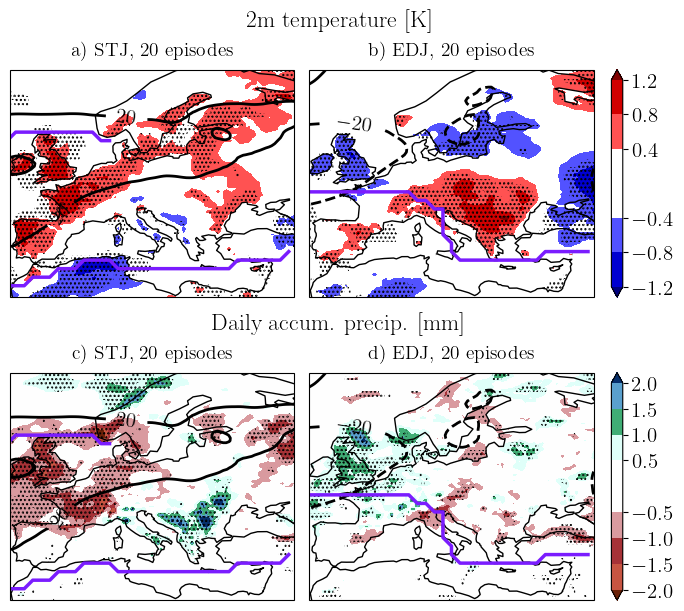

In [10]:
from string import ascii_lowercase
from cartopy.mpl.geoaxes import GeoAxes
plt.rc("axes", titlesize=14)
da_contour = da_z500_anom.sel(time=(da_z500_anom.time.dt.hour == 0) & (da_z500_anom.time.dt.year>=1959), lon=slice(-10, 40), lat=slice(30, 70))
da_1 = da_T_anom.copy().sel(lon=slice(-10, 40), lat=slice(30, 70))
cbar_kwargs = {"shrink": 1.0, "fraction": 0.11, "pad": 0.03}
plot_kwargs_1 = {"cmap": colormaps.BlWhRe, "levels": [-1.2, -0.8, -.4, .4, 0.8, 1.2], "transparify": 1, "hatch": "....", "cbar_kwargs": cbar_kwargs}
da_2 = da_tp_anom.copy().sel(lon=slice(-10, 40), lat=slice(30, 70)) * 1000
plot_kwargs_2 = {
    "cmap": colormaps.precip4_diff_19lev,
    "levels": np.linspace(-2, 2, 9).tolist(),
    "transparify": 0,
    "hatch": "....", 
    "cbar_kwargs": cbar_kwargs,
}
nrow, ncol = 1, 2
days_around = 3
n = nrow * ncol
cmap = colormaps.pastel
norm = BoundaryNorm(np.arange(cmap.N) + 0.5, cmap.N)
bigfig = plt.figure(figsize=(6.8, 6), constrained_layout=True)
subfigs = bigfig.subfigures(2, 1)
for da, plot_kwargs, fig in zip([da_1, da_2], [plot_kwargs_1, plot_kwargs_2], subfigs):
    clu = Clusterplot(nrow, ncol, get_region(da), fig=fig)
    mask = np.zeros((len(da.time), len(spells_list_subset)), dtype=bool)
    titles = []
    for j, jet in enumerate(spells_list_subset):
        spells_from_jet_daily = subset_around_onset(daily_spells_list[jet], around_onset=datetime.timedelta(days=days_around))
        letter = ascii_lowercase[j % len(ascii_lowercase) + len(clu.axes) * int(da.name == "tp")]
        mask[:, j] = np.isin(
            da.time.values,
            spells_from_jet_daily["time"]
        )
        n_spells = spells_from_jet_daily["spell"].n_unique()
        titles.append(f"{letter}) {jet[:3]}, {n_spells} episodes")
    _ = clu.add_any_contour_from_mask(da, mask, type="contourf", stippling=True, titles=titles, **plot_kwargs)
    _ = clu.add_any_contour_from_mask(da_contour, mask, type="contour", levels=[-60, -20, 20, 60], linewidths=2., clabels=True)
    fig.suptitle(long_names[da.name])
    
masked_da = []
time_name = "time"
reduction_function = np.nanmean
for mas in mask.T:
    masked_da.append(ds.sel(time=(ds.time.dt.month.isin([6, 7, 8, 9])) & (ds.time.dt.hour == 0)).isel({time_name: mas}).reduce(reduction_function, dim=time_name))
masked_da = xr.concat(masked_da, dim="relative_index")
jets_on_mean = find_all_jets(masked_da)
for fig in subfigs:
    for ax, (_, jets) in zip(fig.axes, jets_on_mean.group_by("relative_index")):
        if not isinstance(ax, GeoAxes):
            continue
        for _, jet_ in jets.group_by("jet ID"):
            lo, la = jet_[["lon", "lat"]]
            ax.plot(lo - clu.central_longitude, la, lw=2.5, color=COLORS[1])
bigfig.savefig(f"{FIGURES}/jet_persistence/realspace_stuff/t2m_and_tp_realspace_both.png")

In [ ]:
plt.rc("axes", titlesize=13)
da = da_theta2pvu.copy()
cmap = colormaps.amp
plot_kwargs = {"cmap": cmap, "levels": MaxNLocator(11).tick_values(300, 380).tolist()}

nrow, ncol = 14, 2
n = nrow * ncol
for jet in spells_list:
    if jet[-4:] != "catd":
        continue
    clu = Clusterplot(nrow, ncol, get_region(da))
    spells_from_jet_daily = extend_spells(spells_list[jet], time_before=datetime.timedelta(days=1))
    mask = np.zeros((len(da.time), n), dtype=bool)
    titles = []
    for j in range(n):
        letter = ascii_lowercase[i % len(ascii_lowercase)]
        i = j - 4
        this_rel_time = spells_from_jet_daily.filter(pl.col("relative_index")== i)
        mask[:, j] = np.isin(
            da.time.values,
            this_rel_time["time"]
        )
        n_spells = this_rel_time["spell"].n_unique()
        title_0 = f"{np.abs(i)} step{'s' if np.abs(i) > 1 else ''} {'after' if i > 0 else 'before'} onset" if i != 0 else "At onset"
        titles.append(f"{letter}) {title_0}, {n_spells} spells")
    _ = clu.add_any_contour_from_mask(da, mask, stippling=False, titles=titles, cbar_label=long_names[da.name], **plot_kwargs)
    _ = clu.add_any_contour_from_mask(da_s, mask, levels=[25, 35], type="contour", linewidths=2., colors=["green"])    
    masked_da = []
    time_name = "time"
    reduction_function = np.nanmean
    for mas in mask.T:
        masked_da.append(ds.sel(time=ds.time.dt.month.isin([6, 7, 8, 9])).isel({time_name: mas}).reduce(reduction_function, dim=time_name))
    masked_da = xr.concat(masked_da, dim="relative_index").assign_coords(relative_index=np.arange(n) - 4)
    jets_on_mean = find_all_jets(masked_da)
    for j in range(n):
        i = j - 4
        lo, la = jets_on_mean.filter(pl.col("relative_index") == i)[["lon", "lat"]]
        clu.axes[j].scatter(lo - clu.central_longitude, la, marker="x", s=10, color=COLORS[1])
    clu.fig.suptitle(f"Persistent episodes of the {jet[:3]}")
    clu.resize_relative([1.1, 1])
    clu.fig.savefig(f"{FIGURES}/jet_persistence/realspace_stuff/{da.name}_realspace_{jet}.png")
    plt.close()

In [ ]:
plt.rc("axes", titlesize=13)
da = da_theta2pvu_anom.copy()
cmap = colormaps.BlWhRe
plot_kwargs = {"cmap": cmap, "levels": np.arange(-8, 10, 2).tolist()}

nrow, ncol = 14, 2
n = nrow * ncol
for jet in spells_list:
    if jet[-4:] != "catd":
        continue
    clu = Clusterplot(nrow, ncol, get_region(da))
    spells_from_jet_daily = extend_spells(spells_list[jet], time_before=datetime.timedelta(days=1))
    mask = np.zeros((len(da.time), n), dtype=bool)
    titles = []
    for j in range(n):
        letter = ascii_lowercase[i % len(ascii_lowercase)]
        i = j - 4
        this_rel_time = spells_from_jet_daily.filter(pl.col("relative_index")== i)
        mask[:, j] = np.isin(
            da.time.values,
            this_rel_time["time"]
        )
        n_spells = this_rel_time["spell"].n_unique()
        title_0 = f"{np.abs(i)} step{'s' if np.abs(i) > 1 else ''} {'after' if i > 0 else 'before'} onset" if i != 0 else "At onset"
        titles.append(f"{letter}) {title_0}, {n_spells} spells")
    _ = clu.add_any_contour_from_mask(da, mask, stippling=False, titles=titles, cbar_label=long_names[da.name], **plot_kwargs)
    masked_da = []
    time_name = "time"
    reduction_function = np.mean
    for mas in mask.T:
        masked_da.append(ds.sel(time=ds.time.dt.month.isin([6, 7, 8, 9])).isel({time_name: mas}).reduce(reduction_function, dim=time_name))
    masked_da = xr.concat(masked_da, dim="relative_index").assign_coords(relative_index=np.arange(n) - 4)
    jets_on_mean = find_all_jets(masked_da)
    for j in range(n):
        i = j - 4
        lo, la = jets_on_mean.filter(pl.col("relative_index") == i)[["lon", "lat"]]
        clu.axes[j].scatter(lo - clu.central_longitude, la, marker="x", s=10, color="black")
    clu.fig.suptitle(f"Persistent episodes of the {jet[:3]}")
    clu.resize_relative([1.1, 1])
    clu.fig.savefig(f"{FIGURES}/jet_persistence/realspace_stuff/{da.name}_anom_realspace_{jet}.png")
    plt.close()

In [ ]:
from string import ascii_lowercase
plt.rc("axes", titlesize=12)
da = da_tp_anom.copy().sel(lon=slice(-10, 40), lat=slice(30, 70)) * 1000
plot_kwargs = {
    "cmap": colormaps.precip4_diff_19lev,
    "levels": np.linspace(-4.8, 4.8, 13).tolist(),
    "transparify": 0,
    "hatch": "....", "cbar_kwargs": {"shrink": 1., "pad": 0.01}
}
da_contour = da_z500_anom.sel(time=(da_z500_anom.time.dt.hour == 0) & (da_z500_anom.time.dt.year>=1959), lon=slice(-10, 40), lat=slice(30, 70))
nrow, ncol = 3, 2
n = nrow * ncol
clusters_da = np.abs(xr.open_dataarray("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/heatwaves_duncan/cluster_df.nc").load())
clusters_da = clusters_da.interp(lat=np.arange(32, 72, 0.5), method="nearest")
cmap = colormaps.pastel
norm = BoundaryNorm(np.arange(cmap.N) + 0.5, cmap.N)
unique_clusters = np.arange(1, 7)
colors_clusters = cmap(norm(unique_clusters))
bigfig = plt.figure(figsize=(11, 7), constrained_layout=True)
subfigs = bigfig.subfigures(1, 2, width_ratios=[.81, 1])

for jet, fig in zip(spells_list_subset, subfigs):
    clu = Clusterplot(nrow, ncol, get_region(da), fig=fig)
    clusters_da.assign_coords(lon=clusters_da.lon - clu.central_longitude)
    spells_from_jet_daily = daily_spells_list[jet]
    mask = np.zeros((len(da.time), n), dtype=bool)
    titles = []
    for i in range(n):
        letter = ascii_lowercase[i % len(ascii_lowercase)]
        this_rel_time = spells_from_jet_daily.filter(pl.col("relative_index")==i)
        mask[:, i] = np.isin(
            da.time.values,
            this_rel_time["time"]
        )
        n_spells = this_rel_time["spell"].n_unique()
        title_0 = f"{i} day{'s' if i > 1 else ''} after onset" if i > 0 else "At onset"
        titles.append(f"{letter}) {title_0}, {n_spells} alive")
    _ = clu.add_any_contour_from_mask(da, mask, type="contourf", stippling=True, cbar_label=long_names[da.name], titles=titles, **plot_kwargs, draw_cbar=jet=="EDJ_catd")
    _ = clu.add_any_contour_from_mask(da_contour, mask, type="contour", levels=[-60, -20, 20, 60], linewidths=2.)
    masked_da = []
    time_name = "time"
    reduction_function = np.nanmean
    for mas in mask.T:
        masked_da.append(ds.sel(time=(ds.time.dt.month.isin([6, 7, 8, 9])) & (ds.time.dt.hour == 0)).isel({time_name: mas}).reduce(reduction_function, dim=time_name))
    masked_da = xr.concat(masked_da, dim="relative_index").assign_coords(relative_index=np.arange(n) - 4)
    jets_on_mean = find_all_jets(masked_da)
    for j in range(n):
        i = j - 4
        for _, jet_ in jets_on_mean.filter(pl.col("relative_index") == i).group_by("jet ID"):
            lo, la = jet_[["lon", "lat"]]
            clu.axes[j].plot(lo - clu.central_longitude, la, lw=2.5, color=COLORS[1])
    clu.fig.suptitle(f"Persistent episodes of the {jet[:3]}")
bigfig.savefig(f"{FIGURES}/jet_persistence/realspace_stuff/{da.name}_realspace_both.png")

In [110]:
da = da_tp_anom.copy().sel(lon=slice(-10, 40), lat=slice(30, 70)) * 1000
plot_kwargs = {
    "cmap": colormaps.precip4_diff_19lev,
    "levels": 13,
    "q": 0.999,
    "transparify": 0,
}
from string import ascii_lowercase
plt.rc("axes", titlesize=12)
da_contour = da_z500_anom.sel(time=(da_z500_anom.time.dt.hour == 0) & (da_z500_anom.time.dt.year>=1959), lon=slice(-10, 40), lat=slice(30, 70))
# Path(f"{FIGURES}/jet_persistence/realspace_stuff").mkdir(exist_ok=True)
nrow, ncol = 3, 2
n = nrow * ncol
clusters_da = np.abs(xr.open_dataarray("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/heatwaves_duncan/cluster_df.nc").load())
clusters_da = clusters_da.interp(lat=np.arange(32, 72, 0.5), method="nearest")
cmap = colormaps.pastel
norm = BoundaryNorm(np.arange(cmap.N) + 0.5, cmap.N)
unique_clusters = np.arange(1, 7)
colors_clusters = cmap(norm(unique_clusters))
for jet in spells_list:
    if jet[-4:] != "catd":
        continue
    clu = Clusterplot(nrow, ncol, get_region(da))
    clusters_da.assign_coords(lon=clusters_da.lon - clu.central_longitude)
    spells_from_jet_daily = daily_spells_list[jet]
    mask = np.zeros((len(da.time), n), dtype=bool)
    titles = []
    for i in range(n):
        # ax = clu.axes[i]
        # for j in range(6):
        #     ax.contour(clusters_da.lon - clu.central_longitude, clusters_da.lat, clusters_da.where(clusters_da==(j + 1), -1), levels=[.99], colors=[colors_clusters[j]], linewidths=[1.7])
            # ax.contourf(clusters_da.lon - clu.central_longitude, clusters_da.lat, clusters_da.where(clusters_da==(j + 1), -1), levels=[.99, 10], colors=[colors_clusters[j]], alpha=0.5)
            # lo = clusters_da.lon.where(clusters_da==(j + 1)).mean().item() - j - 2 * (j == 0) + 2 * (j == 2) + 1.5 * (j == 1) - (j == 4)  - clu.central_longitude
            # la = clusters_da.lat.where(clusters_da==(j + 1)).mean().item() - (j == 5) * 2
            # color = "black"
            # ax.text(lo, la, DUNCANS_REGIONS_NAMES[j], ha="center", va="center", fontweight="bold", color=color)
        letter = ascii_lowercase[i % len(ascii_lowercase)]
        this_rel_time = spells_from_jet_daily.filter(pl.col("relative_index")==i)
        mask[:, i] = np.isin(
            da.time.values,
            this_rel_time["time"]
        )
        n_spells = this_rel_time["spell"].n_unique()
        title_0 = f"{i} day{'s' if i > 1 else ''} after onset" if i > 0 else "At onset"
        titles.append(f"{letter}) {title_0}, {n_spells} alive")
    _ = clu.add_any_contour_from_mask(da, mask, type="contourf", stippling=True, cbar_label=long_names[da.name], titles=titles, **plot_kwargs, hatch="....")
    _ = clu.add_any_contour_from_mask(da_contour, mask, type="contour", levels=[-60, -20, 20, 60], linewidths=2.)
    masked_da = []
    time_name = "time"
    reduction_function = np.nanmean
    for mas in mask.T:
        masked_da.append(ds.sel(time=(ds.time.dt.month.isin([6, 7, 8, 9])) & (ds.time.dt.hour == 0)).isel({time_name: mas}).reduce(reduction_function, dim=time_name))
    masked_da = xr.concat(masked_da, dim="relative_index").assign_coords(relative_index=np.arange(n) - 4)
    jets_on_mean = find_all_jets(masked_da, base_s_thresh=0.4, int_thresh_factor=0.5)
    for j in range(n):
        i = j - 4
        for _, jet_ in jets_on_mean.filter(pl.col("relative_index") == i).group_by("jet ID"):
            lo, la = jet_[["lon", "lat"]]
            clu.axes[j].plot(lo - clu.central_longitude, la, lw=2.5, color=COLORS[1])
    clu.fig.suptitle(f"Persistent episodes of the {jet[:3]}")
    clu.fig.savefig(f"{FIGURES}/jet_persistence/realspace_stuff/{da.name}_realspace_{jet}.png")
    # plt.close()

## Individual spells

In [26]:
plt.rc("axes", titlesize=13)
da = da_pv330.copy()
cmap = colormaps.amp
plot_kwargs = {"cmap": WERNLI_FLAIR, "levels": WERNLI_FLAIR_LEVELS[:-1]}

nrow, ncol = 3, 2
n = nrow * ncol
key = "EDJ_catd"
spells_from_jet = extend_spells(spells_list[key], time_before=datetime.timedelta(days=1))
# for huh, spell in spells_from_jet.group_by("spell", maintain_order=True):
for j in range(20):
    spell = spells_from_jet.filter(pl.col("spell") == j)
    spell = spell.filter(pl.col("relative_index") % 4 == 0)
    titles = spell["time"].dt.to_string("%Y-%m-%dT%H:%M").to_list()
    # titles = [f"{ascii_lowercase[i]}) {title}" for i, title in enumerate(titles)]
    clu = Clusterplot(nrow, ncol, get_region(da), row_height=3.5)
    to_plot = da.sel(time=spell["time"])
    clu.add_contourf(to_plot, titles=titles, cbar_label=long_names[da.name], **plot_kwargs, cbar_kwargs={"shrink": 0.7})
    for i, t in enumerate(spell["time"]):
        for _, jet in  phat_jets.group_by("jet ID"):
            lo, la, is_p = jet.filter(pl.col("time") == t)[["lon", "lat", "is_polar"]]
            try:
                # clu.axes[i].scatter(lo - clu.central_longitude, la, c=is_p, vmin=0, vmax=1, cmap=colormaps.cet_l_bmw_r, marker="x", s=10)
                color = "black" if len(is_p) > 0 and is_p.mean() > 0.5 else "grey"
                clu.axes[i].plot(lo - clu.central_longitude, la, color=color, lw=3)
            except IndexError:
                continue
    to_plot = das_rwb["TAPVS"].sel(time=spell["time"], lev=slice(320, 340)).any("lev")
    for ax, ouais in zip(clu.axes, to_plot):
        cs = ax.pcolor(
            to_plot.lon.values - clu.central_longitude,
            to_plot.lat.values,
            ouais.where(ouais),
            hatch=r"////",
            facecolor="none", 
            edgecolor="black", 
            hatch_linewidth=1, 
            linewidth=0
        )
    to_plot = das_rwb["TCPVS"].sel(time=spell["time"], lev=slice(320, 340)).any("lev")
    for ax, ouais in zip(clu.axes, to_plot):
        cs = ax.pcolor(
            to_plot.lon.values - clu.central_longitude,
            to_plot.lat.values,
            ouais.where(ouais),
            hatch=r"\\\\", 
            facecolor="none", 
            edgecolor="black", 
            hatch_linewidth=1, 
            linewidth=0
        )
    to_plot = das_rwb["SAPVS"].sel(time=spell["time"], lev=slice(320, 340)).any("lev")
    for ax, ouais in zip(clu.axes, to_plot):
        cs = ax.pcolor(
            to_plot.lon.values - clu.central_longitude,
            to_plot.lat.values,
            ouais.where(ouais),
            hatch="//", 
            facecolor="none", 
            edgecolor=COLORS[2], 
            hatch_linewidth=1, 
            linewidth=0
        )
    to_plot = das_rwb["SCPVS"].sel(time=spell["time"], lev=slice(320, 340)).any("lev")
    for ax, ouais in zip(clu.axes, to_plot):
        cs = ax.pcolor(
            to_plot.lon.values - clu.central_longitude,
            to_plot.lat.values,
            ouais.where(ouais),
            hatch=r"\\",
            facecolor="none", 
            edgecolor=COLORS[2], 
            hatch_linewidth=1, 
            linewidth=0
        )
    clu.fig.savefig(f"{FIGURES}/jet_persistence/realspace_stuff/indiv_spells/pv+streamers_realspace_{key}_spell{j}.png")
    plt.close()

In [27]:
plt.rc("axes", titlesize=13)
da = da_theta2pvu.copy()
cmap = colormaps.bilbao_r
plot_kwargs = {"cmap": cmap, "levels": MaxNLocator(11).tick_values(da.quantile(0.01), da.quantile(0.99)).tolist()}

nrow, ncol = 3, 2
n = nrow * ncol
key = "EDJ_catd"
spells_from_jet = extend_spells(spells_list[key], time_before=datetime.timedelta(days=1))
for j in range(20):
    spell = spells_from_jet.filter(pl.col("spell") == j)
    spell = spell.filter(pl.col("relative_index") % 4 == 0)
    titles = spell["time"].dt.to_string("%Y-%m-%dT%H:%M").to_list()
    # titles = [f"{ascii_lowercase[i]}) {title}" for i, title in enumerate(titles)]
    clu = Clusterplot(nrow, ncol, get_region(da), row_height=3.5)
    to_plot = da.sel(time=spell["time"])
    clu.add_contourf(to_plot, titles=titles, cbar_label=long_names[da.name], **plot_kwargs, cbar_kwargs={"shrink": 0.7})
    for i, t in enumerate(spell["time"]):
        for _, jet in  phat_jets.group_by("jet ID"):
            lo, la, is_p = jet.filter(pl.col("time") == t)[["lon", "lat", "is_polar"]]
            try:
                # clu.axes[i].scatter(lo - clu.central_longitude, la, c=is_p, vmin=0, vmax=1, cmap=colormaps.cet_l_bmw_r, marker="x", s=10)
                color = "black" if len(is_p) > 0 and is_p.mean() > 0.5 else "grey"
                clu.axes[i].plot(lo - clu.central_longitude, la, color=color, lw=3)
            except IndexError:
                continue
    to_plot = das_rwb["TAPVS"].sel(time=spell["time"], lev=slice(320, 340)).any("lev")
    for ax, ouais in zip(clu.axes, to_plot):
        cs = ax.pcolor(
            to_plot.lon.values - clu.central_longitude,
            to_plot.lat.values,
            ouais.where(ouais),
            hatch=r"////",
            facecolor="none", 
            edgecolor="black", 
            hatch_linewidth=1, 
            linewidth=0
        )
    to_plot = das_rwb["TCPVS"].sel(time=spell["time"], lev=slice(320, 340)).any("lev")
    for ax, ouais in zip(clu.axes, to_plot):
        cs = ax.pcolor(
            to_plot.lon.values - clu.central_longitude,
            to_plot.lat.values,
            ouais.where(ouais),
            hatch=r"\\\\", 
            facecolor="none", 
            edgecolor="black", 
            hatch_linewidth=1, 
            linewidth=0
        )
    to_plot = das_rwb["SAPVS"].sel(time=spell["time"], lev=slice(320, 340)).any("lev")
    for ax, ouais in zip(clu.axes, to_plot):
        cs = ax.pcolor(
            to_plot.lon.values - clu.central_longitude,
            to_plot.lat.values,
            ouais.where(ouais),
            hatch="//", 
            facecolor="none", 
            edgecolor=COLORS[2], 
            hatch_linewidth=1, 
            linewidth=0
        )
    to_plot = das_rwb["SCPVS"].sel(time=spell["time"], lev=slice(320, 340)).any("lev")
    for ax, ouais in zip(clu.axes, to_plot):
        cs = ax.pcolor(
            to_plot.lon.values - clu.central_longitude,
            to_plot.lat.values,
            ouais.where(ouais),
            hatch=r"\\",
            facecolor="none", 
            edgecolor=COLORS[2], 
            hatch_linewidth=1, 
            linewidth=0
        )
    clu.fig.savefig(f"{FIGURES}/jet_persistence/realspace_stuff/indiv_spells/theta+streamers_realspace_{key}_spell{j}.png")
    plt.close()

In [28]:
plt.rc("axes", titlesize=13)
da = da_theta2pvu_anom.copy()
cmap = colormaps.BlWhRe
plot_kwargs = {"cmap": cmap, "levels": MaxNLocator(11, symmetric=True).tick_values(da.quantile(0.01), da.quantile(0.99)).tolist()}

nrow, ncol = 3, 2
n = nrow * ncol
key = "EDJ_catd"
spells_from_jet = extend_spells(spells_list[key], time_before=datetime.timedelta(days=1))
for j in range(20):
    spell = spells_from_jet.filter(pl.col("spell") == j)
    spell = spell.filter(pl.col("relative_index") % 4 == 0)
    titles = spell["time"].dt.to_string("%Y-%m-%dT%H:%M").to_list()
    # titles = [f"{ascii_lowercase[i]}) {title}" for i, title in enumerate(titles)]
    clu = Clusterplot(nrow, ncol, get_region(da), row_height=3.5)
    to_plot = da.sel(time=spell["time"])
    clu.add_contourf(to_plot, titles=titles, cbar_label=long_names[da.name], **plot_kwargs, cbar_kwargs={"shrink": 0.7})
    for i, t in enumerate(spell["time"]):
        for _, jet in  phat_jets.group_by("jet ID"):
            lo, la, is_p = jet.filter(pl.col("time") == t)[["lon", "lat", "is_polar"]]
            try:
                # clu.axes[i].scatter(lo - clu.central_longitude, la, c=is_p, vmin=0, vmax=1, cmap=colormaps.cet_l_bmw_r, marker="x", s=10)
                color = "black" if len(is_p) > 0 and is_p.mean() > 0.5 else "grey"
                clu.axes[i].plot(lo - clu.central_longitude, la, color=color, lw=3)
            except IndexError:
                continue
    to_plot = das_rwb["TAPVS"].sel(time=spell["time"], lev=slice(320, 340)).any("lev")
    for ax, ouais in zip(clu.axes, to_plot):
        cs = ax.pcolor(
            to_plot.lon.values - clu.central_longitude,
            to_plot.lat.values,
            ouais.where(ouais),
            hatch=r"////",
            facecolor="none", 
            edgecolor="black", 
            hatch_linewidth=1, 
            linewidth=0
        )
    to_plot = das_rwb["TCPVS"].sel(time=spell["time"], lev=slice(320, 340)).any("lev")
    for ax, ouais in zip(clu.axes, to_plot):
        cs = ax.pcolor(
            to_plot.lon.values - clu.central_longitude,
            to_plot.lat.values,
            ouais.where(ouais),
            hatch=r"\\\\", 
            facecolor="none", 
            edgecolor="black", 
            hatch_linewidth=1, 
            linewidth=0
        )
    to_plot = das_rwb["SAPVS"].sel(time=spell["time"], lev=slice(320, 340)).any("lev")
    for ax, ouais in zip(clu.axes, to_plot):
        cs = ax.pcolor(
            to_plot.lon.values - clu.central_longitude,
            to_plot.lat.values,
            ouais.where(ouais),
            hatch="//", 
            facecolor="none", 
            edgecolor=COLORS[2], 
            hatch_linewidth=1, 
            linewidth=0
        )
    to_plot = das_rwb["SCPVS"].sel(time=spell["time"], lev=slice(320, 340)).any("lev")
    for ax, ouais in zip(clu.axes, to_plot):
        cs = ax.pcolor(
            to_plot.lon.values - clu.central_longitude,
            to_plot.lat.values,
            ouais.where(ouais),
            hatch=r"\\",
            facecolor="none", 
            edgecolor=COLORS[2], 
            hatch_linewidth=1, 
            linewidth=0
        )
    clu.fig.savefig(f"{FIGURES}/jet_persistence/realspace_stuff/indiv_spells/thetaanom+streamers_realspace_{key}_spell{j}.png")
    plt.close()

In [58]:
da_tp = open_da(
    "ERA5",
    "surf",
    "tp",
    "dailysum",
    "all", 
    None, 
    *(-80, 40, 0, 60),
    "all",
)
da_tp = compute(da_tp, progress_flag=True)

[########################################] | 100% Completed | 121.44 s


In [70]:
exp.path

PosixPath('/storage/workspaces/giub_meteo_impacts/ci01/ERA5/plev/high_wind/6H/results/7')

In [67]:
r1 = (-80, -40, 30, 50)
huh = extract_region(da_tp, *r1).sum(["lon", "lat"]) / rectangle_area(*r1)
r2 = (-80, 40, 0, 20)
huh2 = extract_region(da_tp, *r2).sum(["lon", "lat"]) / rectangle_area(*r2)

In [72]:
xarray_to_polars(huh).cast({"time": pl.Datetime("ms")}).write_parquet(exp.path.joinpath("tp_wnatl.parquet"))

In [73]:
xarray_to_polars(huh2).cast({"time": pl.Datetime("ms")}).write_parquet(exp.path.joinpath("tp_tropnatl.parquet"))

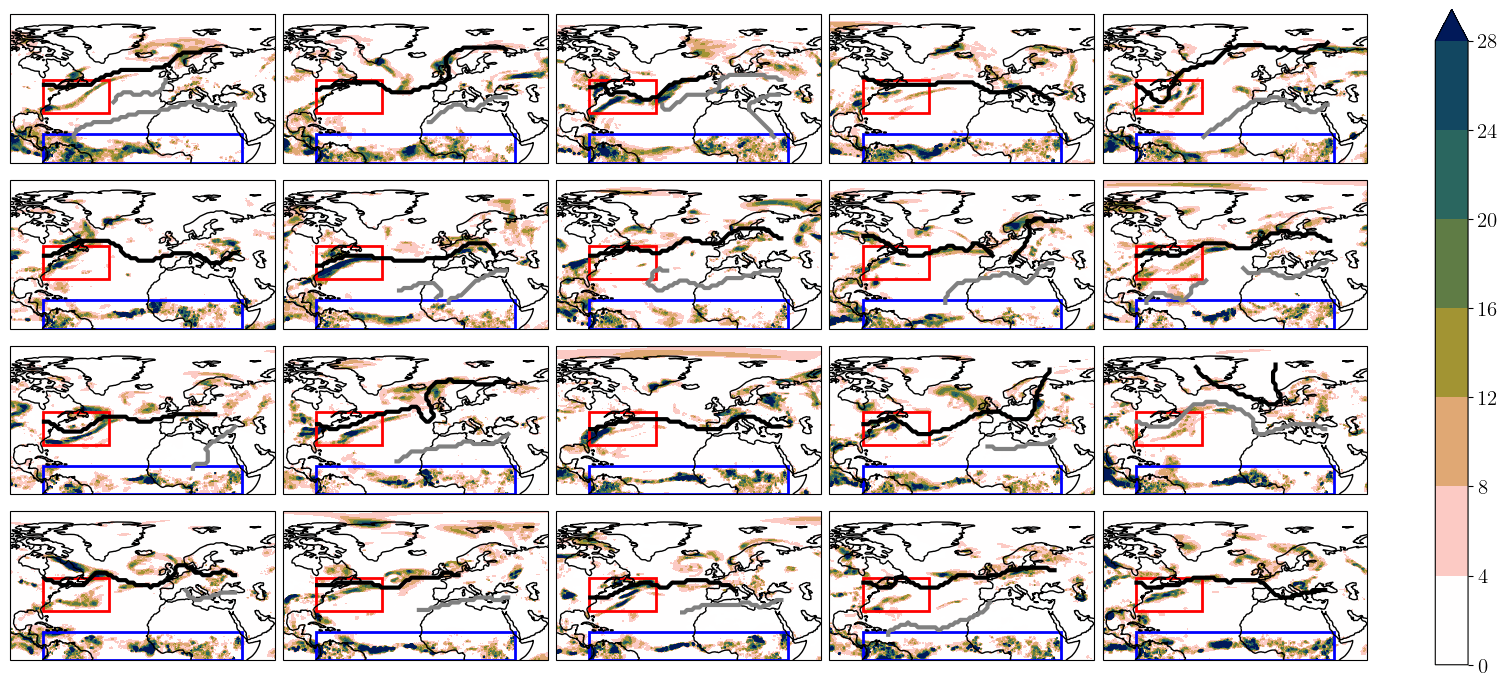

In [56]:
from matplotlib.patches import Rectangle
plt.rc("axes", titlesize=13)
da = da_tp.copy() * 1000
cmap = colormaps.batloww_r
plot_kwargs = {"cmap": cmap, "levels": MaxNLocator(7, symmetric=False).tick_values(0, da.quantile(0.99)).tolist()}

nrow, ncol = 3, 2
n = nrow * ncol
key = "EDJ_catd"
spells_from_jet = spells_list[key].filter(pl.col("relative_index") == 0)
clu = Clusterplot(4, 5, get_region(da))
to_plot = da.sel(time=spells_from_jet["time"].dt.round("1d"))
clu.add_contourf(to_plot, **plot_kwargs)
for i, t in enumerate(spells_from_jet["time"].dt.round("1d")):
    for _, jet in  phat_jets.group_by("jet ID"):
        lo, la, is_p = jet.filter(pl.col("time") == t)[["lon", "lat", "is_polar"]]
        try:
            # clu.axes[i].scatter(lo - clu.central_longitude, la, c=is_p, vmin=0, vmax=1, cmap=colormaps.cet_l_bmw_r, marker="x", s=10)
            color = "black" if len(is_p) > 0 and is_p.mean() > 0.5 else "grey"
            clu.axes[i].plot(lo - clu.central_longitude, la, color=color, lw=3)
        except IndexError:
            continue
    rect = Rectangle((-80 - clu.central_longitude, 30), 40, 20, linewidth=2, edgecolor='r', facecolor='none')
    clu.axes[i].add_patch(rect)
    rect = Rectangle((-80 - clu.central_longitude, 0), 120, 17, linewidth=2, edgecolor='b', facecolor='none')
    clu.axes[i].add_patch(rect)

#